In [1]:
from free_lie_algebra import *
from transformers import *

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

from yellowbrick.regressor import ResidualsPlot, PredictionError

from esig import tosig

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
class AddStepFunction(BaseEstimator, TransformerMixin):
    def __init__(self, steps, amplitude=None):
        self.steps = steps
        self.amplitude = amplitude            

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X, step):
        if self.amplitude is None:
            self.amplitude = max(np.abs(X))
        t = np.linspace(0, self.amplitude, len(X))
        tt = np.array([t[i] if i%step==0 else t[int(i/step)*step] for i in range(len(t))])
        return np.c_[tt, X]

    def transform(self, X, y=None):
        return [self.transform_instance(x, step) for x, step in zip(X, self.steps)]

In [4]:
class LeadLag_modified(BaseEstimator, TransformerMixin):
    
    def __init__(self, amount):
        self.amount = amount

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        lag = []
        lead = []
        N = len(X)
        lead += [X[0]]
        for j in range(self.amount*(N-1)):
            if j%self.amount == 0:
                    lead += [X[int(j/self.amount)+1]]*self.amount
                    lag += [X[int(j/self.amount)]]*self.amount
        lag += [X[-1]]
        return np.c_[lead, lag]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

# Simulate data

In [5]:
def Relu(x):
    return np.max([x, 0])

def Simulate1SqrtU(T, N, U):
    # Simulte a path:
    # t ->  sqrt(( t - U)+)
    # t in [0, T]
    # N - number of time steps.
    ts = np.arange(N)*T/float(N)
    vRelu = np.vectorize(Relu)
    Signal = np.sqrt(vRelu(ts-U))
    DifSignal = Signal[1:]- Signal[:-1]
    #print(Signal)  
    return DifSignal

def SimulateMultiSplikePath(T, N, C, nSpikes):
    # N - the length of time series
    # T - the terminal time
    # nSpikes - number of spikes 
    tSpikes = np.sort(np.random.choice(N, nSpikes, replace=False), axis=0)
    path = np.zeros((N-1, ), dtype = float)
    signVec = []
    for i in tSpikes:
        sign = random.randint(0, 1)
        signVec.append(sign)
        path = path + (2*sign-1)*Simulate1SqrtU( T, N, float(i*T/N))
    path  = path + C*np.random.normal(0, float(T/N), N-1)
    a = ''.join(map(str, signVec))
    return path, signVec

def SimulateDataSet(N_samples, C, T, N, nSpikes):
    X = []
    y = []
    for i in range(N_samples):
        path, signs = SimulateMultiSplikePath(T, N, C, nSpikes[i])
        X.append(path)
        y.append(signs)
    return X, [sum(k) for k in y] # number of up spikes

# Simple example about what we mean

In [6]:
# N_samples = 3
# T = 1
# N = 700
# C = 0.2
# nSpikes = [100]*3
# X, y = SimulateDataSet(N_samples, C, T, N, nSpikes)

# fig, axes = plt.subplots(N_samples+1, 1, figsize=(17, 15), sharex=True)

# # first path
# axes[0].plot(np.arange(N-1)*T/N, X[0], c='blue')
# axes[0].set_ylabel('$X_t$')
# axes[0].set_title('X_t')

# # second path
# axes[1].plot(np.arange(N-1)*T/N, X[1], c='green')
# axes[1].set_ylabel('$Y_t$')
# axes[1].set_title('Y_t')

# # third path
# axes[2].plot(np.arange(N-1)*T/N, X[2], c='red')
# axes[2].set_ylabel('$Z_t$')
# axes[2].set_title('Z_t')

# # concatenation
# r = N_samples
# concatenated_path = np.concatenate((X[0], X[1], X[2]))
# axes[3].scatter(np.arange(r*(N-1))*T/(r*N), concatenated_path, c=['blue']*(N-1) + ['green']*(N-1) + ['red']*(N-1), s=5)
# axes[3].plot(np.arange(r*(N-1))*T/(r*N), concatenated_path, 'black', alpha=0.3)
# axes[3].set_xlabel('t')
# axes[3].set_ylabel('$conc(X_t, Y_t, Z_t)$')
# axes[3].set_title('Concatenation of the {} paths, reparametrized to [0, {}]'.format(r, T))
# plt.show()

# Generate data-set for supervised learning

### Local pathlets

In [6]:
N_samples = 1000 # total number of short paths forming a big path
max_spike = 5 # max number of spikes per short path
T = 1. # end time
N = 300 # number of points on each short path
C = 0.2 # constant for the stochastic process

# generate list of random numbers of spikes for each sub-path
nSpikes = list(np.random.randint(1, max_spike, N_samples))

# simulate list of sub-paths
X, y = SimulateDataSet(N_samples, C, T, N, nSpikes)
sumX = [np.cumsum(x) for x in X]

# time-augmented path
time_transformer = AddTime()
X_addtime = time_transformer.fit_transform(sumX)

# lead-lagged 2 path
lead_lag_transformer2 = LeadLag_modified(amount=2)
X_leadlag2 = lead_lag_transformer2.fit_transform(X)

# lead-lagged 4 path
lead_lag_transformer4 = LeadLag_modified(amount=4)
X_leadlag4 = lead_lag_transformer4.fit_transform(X)

# step_function-augmented path
step_transformer = AddStepFunction(steps=[int(N/sp) for sp in nSpikes])
X_step = step_transformer.fit_transform(X)

# local targets
# y = [np.abs(np.max(x)) + np.abs(np.min(x)) for x in X]

local_paths = [X_addtime, 
               X_leadlag2, 
               X_leadlag4, 
               X_step]

### Global paths

In [89]:
N_samples = 1000
min_spike = 20
max_spike = 100 
T = 1.
N = 7000 
C = 0.2 
    
# generate list of random numbers of spikes for each sub-path
nSpikes = list(np.random.randint(min_spike, max_spike, N_samples))
    
# simulate list of sub-paths
X, Y = SimulateDataSet(N_samples, C, T, N, nSpikes)
sumX = [np.cumsum(x) for x in X]

# time-augmented path
time_transformer = AddTime()
X_addtime_long = time_transformer.fit_transform(sumX)

# lead-lagged 2 path
lead_lag_transformer2 = LeadLag_modified(amount=2)
X_leadlag2_long = lead_lag_transformer2.fit_transform(X)

# lead-lagged 4 path
lead_lag_transformer4 = LeadLag_modified(amount=4)
X_leadlag4_long = lead_lag_transformer4.fit_transform(X)

# step_function-augmented path
step_transformer = AddStepFunction(steps=[int(N/sp) for sp in nSpikes])
X_step_long = step_transformer.fit_transform(X)

# global targets
# Y = [np.abs(np.max(x)) + np.abs(np.min(x)) for x in X]

global_paths = [X_addtime_long, 
                X_leadlag2_long, 
                X_leadlag4_long, 
                X_step_long]

In [90]:
names = ['time-augmented', 
         'lead-lag-2', 
         'lead-lag-4', 
         'step-function']

# Supervised learning

In [10]:
def PredictionError_plot(input_paths, targets, depth, title=None, axes=None, colors=None, 
                         normalization_flag=True, intercept_flag=False):
    
    # calculate signatures
    X = [tosig.stream2sig(x, depth) for x in input_paths]
        
    # split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2)
    
    # local regression
    lin_reg = LinearRegression(fit_intercept=intercept_flag, normalize=normalization_flag)
    
    if title is None:
        visualizer = PredictionError(lin_reg)
    else:
        visualizer = PredictionError(lin_reg, title=title, ax=axes, point_color=colors[0], line_color=colors[1])
    
    visualizer.fit(np.array(X_train), np.array(y_train).astype(float).reshape(-1, ))
    visualizer.score(np.array(X_test), np.array(y_test).astype(float).reshape(-1, ))
    visualizer.finalize()

In [11]:
def Residuals_plot(input_paths, targets, depth, title=None, axes=None, normalization_flag=False, intercept_flag=False):
    
    # signatures
    X = [tosig.stream2sig(x, depth) for x in input_paths]
        
    # split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2)
    
    # local regression
    lin_reg = LinearRegression(fit_intercept=intercept_flag, normalize=normalization_flag)
    
    if title is None:
        visualizer = ResidualsPlot(lin_reg)
    else:
        visualizer = ResidualsPlot(lin_reg, title=title, ax=axes)
        
    visualizer.fit(np.array(X_train), np.array(y_train).astype(float).reshape(-1, 1))
    visualizer.score(np.array(X_test), np.array(y_test).astype(float).reshape(-1, 1))
    visualizer.finalize()

# Deep log-signatures on digits

# Sig o Sig for time-transformed dyadic

In [25]:
paths = X_addtime_long
dyadic_depth = 8
dyadic_transformer = Dyadic(depth=dyadic_depth)
X_dyadic = dyadic_transformer.fit_transform(paths)
dyadic_signatures = [tosig.stream2sig(np.array([tosig.stream2sig(x, 2) for x in LL]), 2) for LL in X_dyadic]

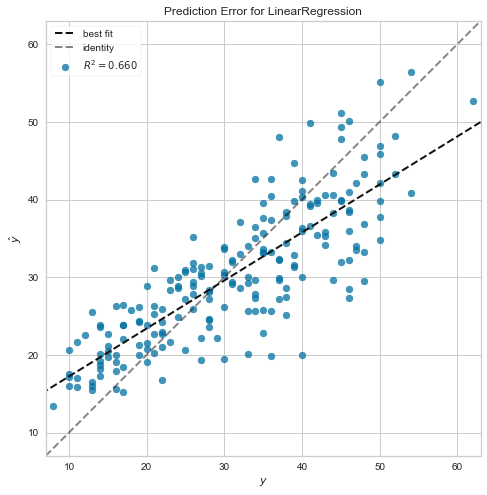

In [26]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(dyadic_signatures, Y, test_size=0.2)

# local regression
lin_reg = LinearRegression()
visualizer = PredictionError(lin_reg)
visualizer.fit(np.array(X_train), np.array(y_train).astype(float).reshape(-1, ))
visualizer.score(np.array(X_test), np.array(y_test).astype(float).reshape(-1, ))
visualizer.finalize()

# Sig o Sig for lead-lag-transform dyadic

In [51]:
dyadic_depth = 7
dyadic_transformer = Dyadic(depth=dyadic_depth)
X_dyadic = dyadic_transformer.fit_transform(X)
paths = [LeadLag_modified(amount=8).fit_transform(x) for x in X_dyadic]
dyadic_signatures = [tosig.stream2sig(np.array([tosig.stream2sig(x, 2) for x in LL]), 4) for LL in paths]

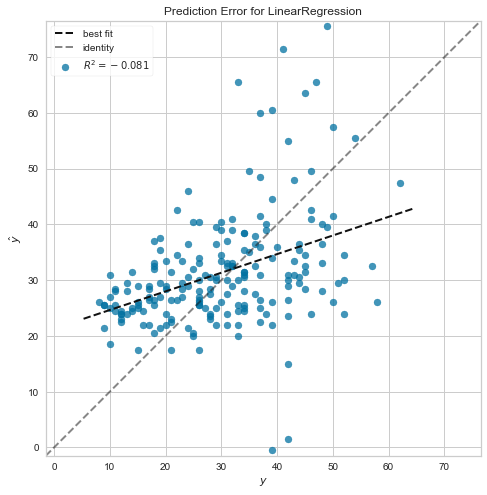

In [52]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(dyadic_signatures, Y, test_size=0.2)

# local regression
lin_reg = LinearRegression()
visualizer = PredictionError(lin_reg)
visualizer.fit(np.array(X_train), np.array(y_train).astype(float).reshape(-1, ))
visualizer.score(np.array(X_test), np.array(y_test).astype(float).reshape(-1, ))
visualizer.finalize()

# Regression Predictions Analysis

### Local


 
 results with time-augmented path-transform 

local model with signatures degree = 2
local model with signatures degree = 3
local model with signatures degree = 4

 
 results with lead-lag-2 path-transform 

local model with signatures degree = 2
local model with signatures degree = 3
local model with signatures degree = 4

 
 results with lead-lag-4 path-transform 

local model with signatures degree = 2
local model with signatures degree = 3
local model with signatures degree = 4

 
 results with step-function path-transform 

local model with signatures degree = 2
local model with signatures degree = 3
local model with signatures degree = 4


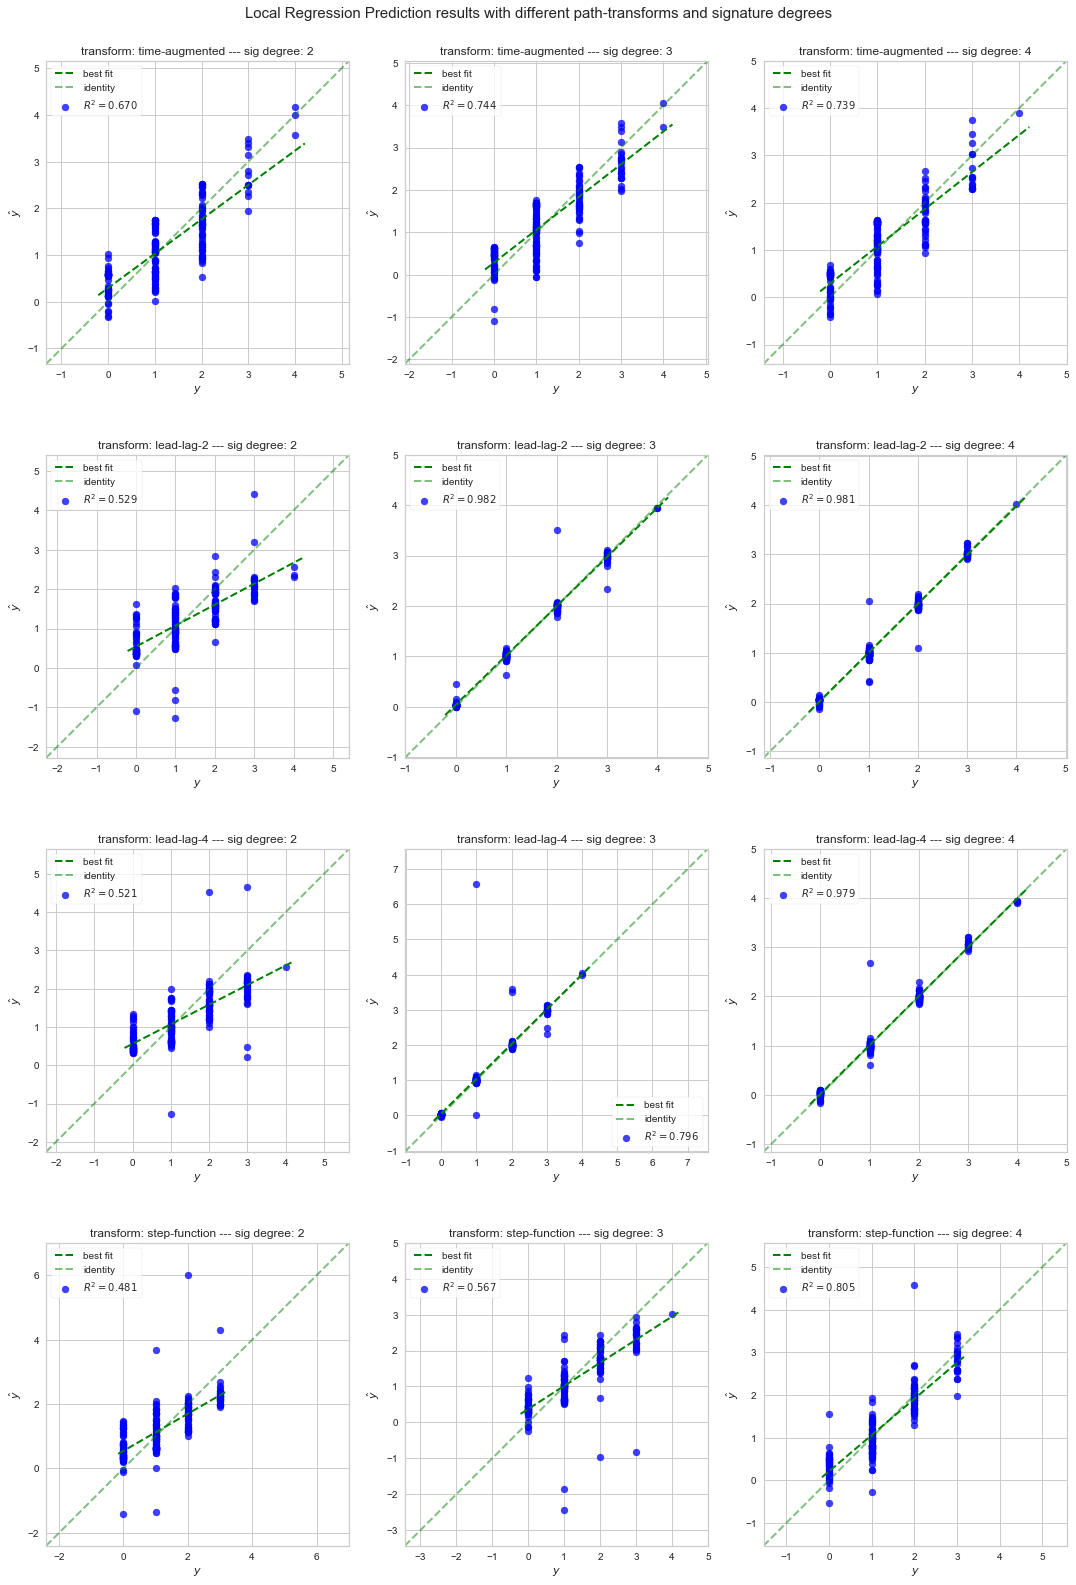

In [13]:
sig_depths = [2, 3, 4]

fig, ax = plt.subplots(len(local_paths), len(sig_depths), figsize=(20,25))

i,j=0,0

for lp, name in zip(local_paths, names):
    
    print('\n \n results with {} path-transform \n'.format(name))
    
    for d in sig_depths:
        
        print('local model with signatures degree = {}'.format(d))
        
        title = 'transform: {} --- sig degree: {}'.format(name, d)
        
#         s = Residuals_plot(input_paths=lp, targets=y, axes=ax[j, i], colors=['blue', 'green'], title=title, depth=d)
        s = PredictionError_plot(input_paths=lp, targets=y, axes=ax[j, i], colors=['blue', 'green'], title=title, depth=d)
        
        i+=1
    
    i=0
    j+=1

plt.suptitle('Local Regression Prediction results with different path-transforms and signature degrees', fontsize=15)
plt.subplots_adjust(wspace=-0.1, hspace=0.3, top=0.95)
plt.show()

### Global paths


 
 results with time-augmented path-transform 

global model with signatures degree = 2
global model with signatures degree = 3
global model with signatures degree = 4
global model with signatures degree = 5
global model with signatures degree = 6

 
 results with lead-lag-2 path-transform 

global model with signatures degree = 2
global model with signatures degree = 3
global model with signatures degree = 4
global model with signatures degree = 5
global model with signatures degree = 6

 
 results with lead-lag-4 path-transform 

global model with signatures degree = 2
global model with signatures degree = 3
global model with signatures degree = 4
global model with signatures degree = 5
global model with signatures degree = 6

 
 results with step-function path-transform 

global model with signatures degree = 2
global model with signatures degree = 3
global model with signatures degree = 4
global model with signatures degree = 5
global model with signatures degree = 6


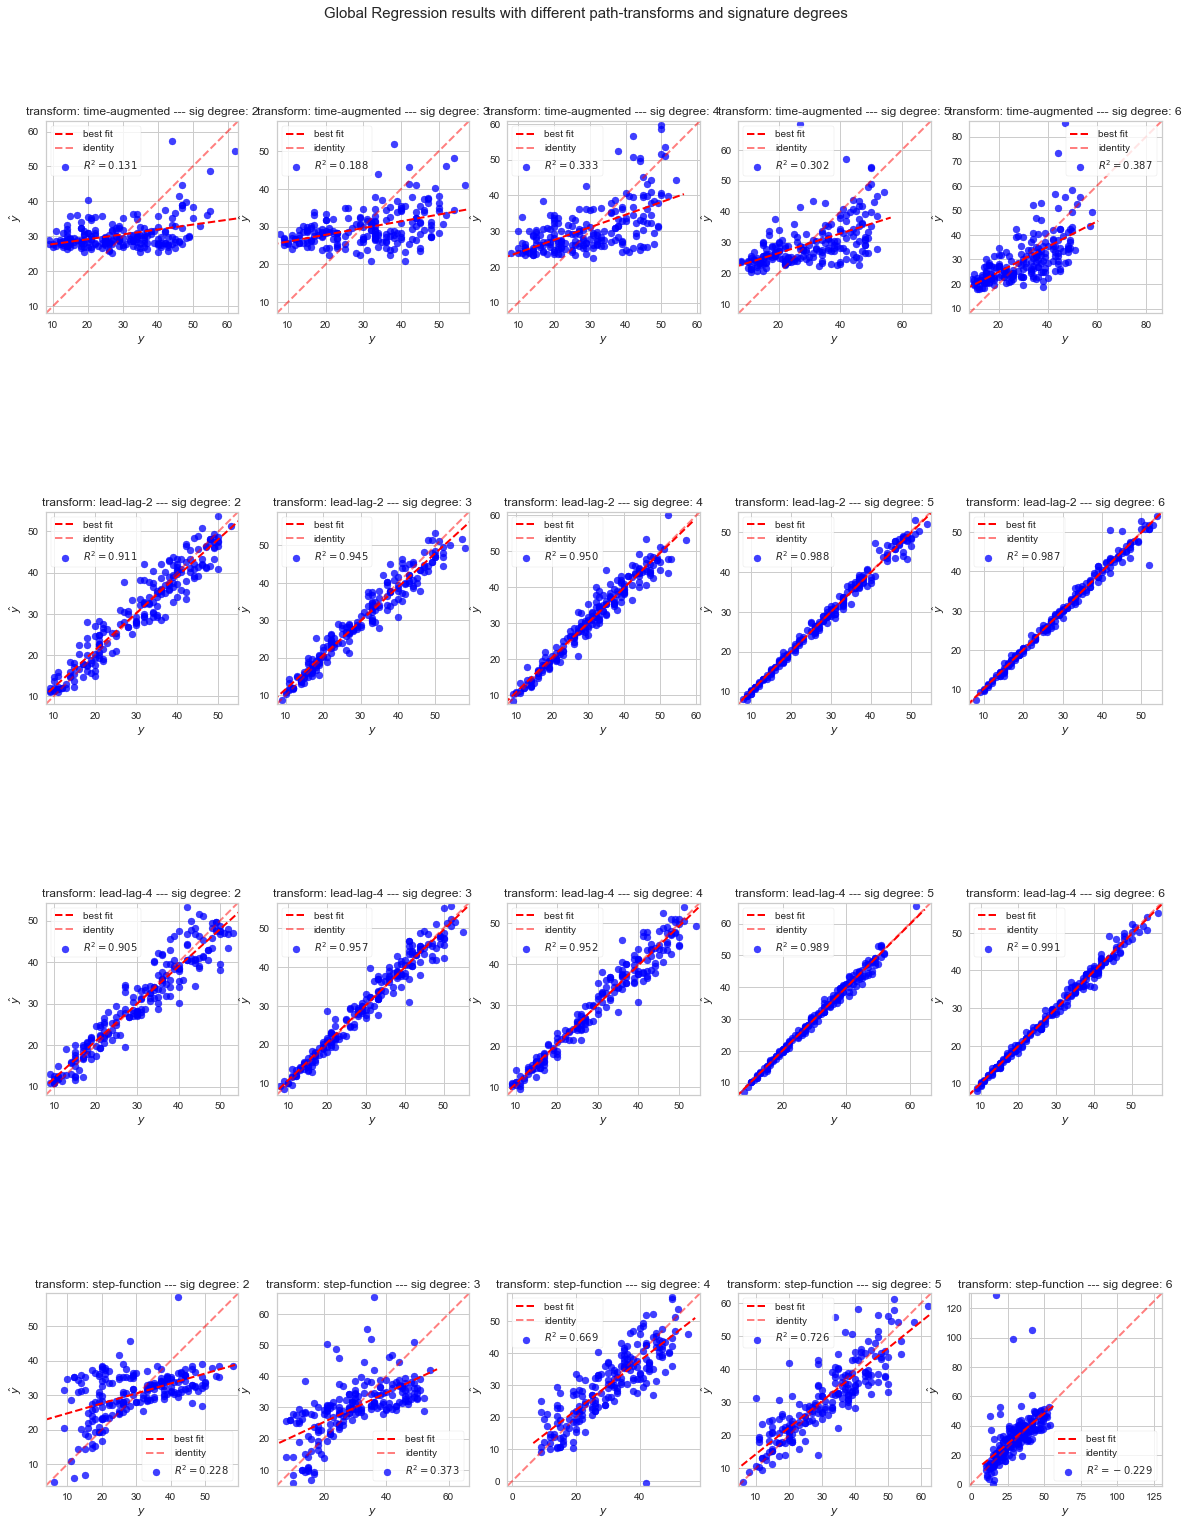

In [12]:
sig_depths = [2, 3, 4, 5, 6]
fig, ax = plt.subplots(len(global_paths), len(sig_depths), figsize=(20, 25))
i,j=0,0

for gp, name in zip(global_paths, names):
    
    print('\n \n results with {} path-transform \n'.format(name))
    
    for d in sig_depths:
        
        print('global model with signatures degree = {}'.format(d))
        
        title = 'transform: {} --- sig degree: {}'.format(name, d)
        
        s = PredictionError_plot(input_paths=gp, targets=Y, axes=ax[j,i], title=title, colors=['blue', 'red'], depth=d)
        
        i+=1
    
    i=0
    j+=1

plt.suptitle('Global Regression results with different path-transforms and signature degrees', fontsize=15)
plt.subplots_adjust(wspace=0.2, hspace=0.25, top=0.95)
plt.show()

# MSE Analysis

In [494]:
def model(input_paths, targets, depth=2, normalization_flag=False, intercept_flag=False):
    
    X = [tosig.stream2sig(x, depth) for x in input_paths]
        
    # split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)
    
    # local regression
    lin_reg = LinearRegression(fit_intercept=intercept_flag, normalize=normalization_flag)
    lin_reg.fit(np.array(X_train), np.array(y_train).astype(float).reshape(-1, 1))

    # mse
    return mean_squared_error(lin_reg.predict(np.array(X_test)), np.array(y_test).astype(float).reshape(-1, 1))

In [495]:
results = {}
for lp, gp, name in zip(local_paths, global_paths, names):
    lll = {}
    ggg = {}
    print('\n \n \n computing results with {} path-transform \n'.format(name))
    # local regression
    print('--- local regression --- \n')
    for dl in [2, 3, 4, 5]:
        print('fitting local model with signatures degree = {}'.format(dl))
        lll[dl] = model(input_paths=lp, targets=y, depth=dl)
    # global regression
    print('\n --- global regression --- \n')
    for dg in [3, 4, 5, 6]:
        print('fitting global model with signatures degree = {}'.format(dg))
        ggg[dg] = model(input_paths=gp, targets=Y, depth=dg)
    results[name] = {'local':lll, 'global':ggg}


 
 
 computing results with time-augmented path-transform 

--- local regression --- 

fitting local model with signatures degree = 2
fitting local model with signatures degree = 3
fitting local model with signatures degree = 4
fitting local model with signatures degree = 5

 --- global regression --- 

fitting global model with signatures degree = 3
fitting global model with signatures degree = 4
fitting global model with signatures degree = 5
fitting global model with signatures degree = 6

 
 
 computing results with lead-lag-2 path-transform 

--- local regression --- 

fitting local model with signatures degree = 2
fitting local model with signatures degree = 3
fitting local model with signatures degree = 4
fitting local model with signatures degree = 5

 --- global regression --- 

fitting global model with signatures degree = 3
fitting global model with signatures degree = 4
fitting global model with signatures degree = 5
fitting global model with signatures degree = 6

 
 
 co

In [496]:
df_time = pd.DataFrame.from_dict(results['time-augmented'], orient='index').T
df_leadlag2 = pd.DataFrame.from_dict(results['lead-lag-2'], orient='index').T
df_leadlag4 = pd.DataFrame.from_dict(results['lead-lag-4'], orient='index').T
df_step = pd.DataFrame.from_dict(results['step-function'], orient='index').T

In [497]:
df_local = pd.concat([df_time.local, df_leadlag2.local, df_leadlag4.local, df_step.local], axis=1).dropna()
df_local.columns = [n +' MSE' for n in names]

df_global = pd.concat([df_time['global'], df_leadlag2['global'], df_leadlag4['global'], df_step['global']], axis=1).dropna()
df_global.columns = [n +' MSE' for n in names]

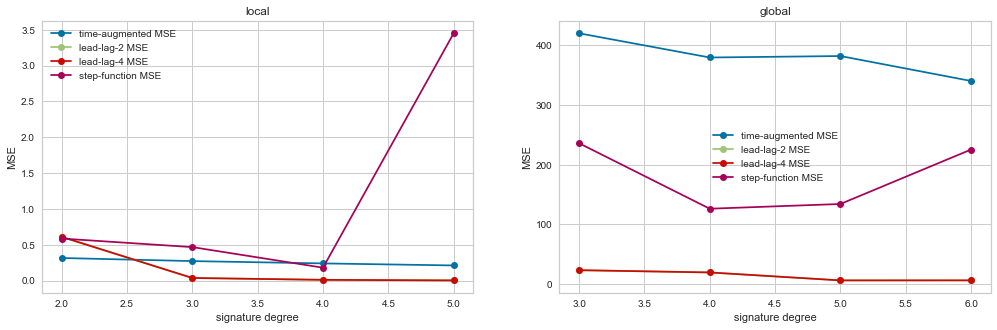

In [498]:
# plt.figure(figsize=(15, 10))
fig, ax = plt.subplots(1, 2, figsize=(17,5))
i=0
for df,tt in zip([df_local, df_global], ['local', 'global']):
    df.plot(marker='o', grid=True, title=tt, ax=ax[i])
    ax[i].set_ylabel('MSE')
    ax[i].set_xlabel('signature degree')
    i+=1
plt.show()